<a href="https://colab.research.google.com/github/cerezamo/NLP_brouillon/blob/master/Camembert_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CamemBERT classification model 


In [1]:
import spacy 
import numpy as np 
import pandas as pd 
import os 
os.getcwd()
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Set up Colab GPU 

In [2]:
#%tensorflow_version 1.x
# First you should go in 'Edit' -> 'Notebook settings' -> Add device GPU
import tensorflow as tf


# GPU device name.
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

Let's now tell torch that one GPU is available 

In [3]:
import torch

if torch.cuda.is_available():  
        
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4








Please check GPU capacity that you were given. You might want to reduce the batch size further in the code. 

Let's install the Hugging Face Library transformer package 

In [4]:
! pip install transformers 

## Loading our corpus and preparing samples 

In [0]:
# We keep the same seed value all along this notebook in order to be able to replicate the results 
seed_val = 2003

In [0]:
# Import medium_df_desq in "files" (on the left) => ICI prendre du github ??
import pandas as pd

# Load the dataset into a pandas dataframe.
df=pd.read_csv('medium_df_deseq.csv',encoding='utf-8')
# Shuffle the date
df=df.sample(frac=1,random_state=seed_val).reset_index(drop=True)
# Some of the speeches are interviews (wrongly classified in the website) we try to delte them here 
df=df[~df.Texte.str.startswith("Q-")]
df=df[~df.Texte.str.startswith("R-")]

# We replace the labels in a more normalized way : 0=men, 1=women 
df.sexe=df.sexe.replace(1,0)
df.sexe=df.sexe.replace(2,1)

In [0]:
# We keep only variables of interest 
df=df[['Id','Titre','Theme','Prenom','Nom','Date','Tags','Texte','sexe']]

In [13]:
# This is a sample of our dataset
df.head(5)

,Id,Titre,Theme,Prenom,Nom,Date,Tags,Texte,sexe
0,160153,"Déclaration de Mme Michèle Alliot-Marie, minis...",Société,Michèle,Alliot-Marie,2006-01-23T12:00:00Z,"Sécurité,Gendarmerie",C'est une grande satisfaction d'être aujourd'h...,1
1,149333,"Déclaration de M. François Baroin, ministre de...",Institutions,François,Baroin,2005-06-11T12:00:00Z,"Citoyenneté - Elections,Parti politique",Mes premiers mots iront vers nos amis d'Outre-...,0
2,178463,"Déclaration de M. Xavier Darcos, ministre du t...",NaN,Xavier,Darcos,2010-01-12T12:00:00Z,NaN,"Comme vous le savez, après la réforme engagée ...",0
3,180716,"Déclaration de Mme Nathalie Kosciusko-Morizet,...",Economie,Nathalie,Kosciusko-Morizet,2010-12-03T12:00:00Z,"Vie économique,Tourisme","Messieurs les présidents,Mesdames, Messieurs,J...",1
4,153024,"Déclaration de M. Jack Lang, ministre de l'édu...",Société,Jack,Lang,2000-11-22T12:00:00Z,"Sciences - Numérique - I. A.,Economie numériqu...",Je suis heureux de voir que le salon de l'éduc...,0


In [0]:
# For the cleaning part we will just remove urls from the text 
import re
def remove_urls (text):
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    return text 

df['Texte']=df.Texte.apply(remove_urls)

**We propose 3 samples to train our model :**


1.   **Unbalanced sample**

We take the raw data without any further treatment.

2.   **Balanced sample**

The second option consist in deleting randomly part of male speeches in order to get a balanced sample. Indeed, in the case of unbalanced sample our model could decide to classify all speakers in the male category which would lead to a 0.75 accuracy in our case study. In order to avoid this we feed the model with the same proportions of male and female speakers. Other kind of treatments exist to deal with unbalanced sample. This one is the simpliest one and we could argue that there is a possibility that the deleted sample contains important information that we therefore miss. However we believe that in our case this is not a big issue. Our unbalanced sample is quite large for both female and male.

3. **Balanced and splitted sample**

The third option is a response to the max length constraint of BERT models. Our text samples are big and contain much more tokens than the 512 limit. In the first two options we decide to just feed the model with the 512 first tokens and thus delete the rest of them. In this third option we cut the text into x parts containing 500 tokens each. All parts of the speech will serve to feed the model. By this technique we do not loose potential important informations at the end of the text. A lot of other techniques have been employed (see ref !!! PUT). We decide to stick to this one in this project. 



In [0]:
def unbalanced_preprocess(df,seed_val,frac_val):

  from sklearn.model_selection import train_test_split

  #Shuffle the data 
  #df_unbalanced=df.sample(frac=frac_val).reset_index()
  df_unbalanced=df

  # Report the number of speeches in the corpus.
  print('Number of text in the unbalanced corpus : {:,}\n'.format(df_unbalanced.shape[0]))
  prop = (len(df_unbalanced[df_unbalanced.sexe==1])/len(df_unbalanced))*100
  print('Proportions of women in the unbalanced corpus : {}\n'.format(prop))

  return df_unbalanced

In [16]:
df_unbalanced = unbalanced_preprocess(df,seed_val,frac_val=1) 

Number of text in the unbalanced corpus : 4,998

Proportions of women in the unbalanced corpus : 25.010004001600638



In [0]:
def balanced_preprocess(df,seed_val,frac_val):
  from sklearn.model_selection import train_test_split

  # Let's take a balanced sample 
  df_m = df.loc[df['sexe'] == 0]
  df_f = df.loc[df['sexe'] == 1] 
  df_m = df_m[0:len(df_f)]
  df = df_f.append(df_m)

  #Shuffle the data and taking half of the sample in order not to have to many data compared to the other samples 
  df_balanced=df.sample(frac=frac_val,random_state=seed_val).reset_index()

  # Report the number of speeches in the corpus.
  print('Number of text in this corpus : {:,}\n'.format(df_balanced.shape[0]))
  prop = (len(df_balanced[df_balanced.sexe==1])/len(df_balanced))*100
  print('Proportions of women in the balanced corpus : {}\n'.format(prop))

  return df_balanced



In [8]:
df_balanced = balanced_preprocess(df,seed_val,frac_val=1)

Number of text in this corpus : 2,500

Proportions of women in the balanced corpus : 50.0



In [0]:
import pandas as pd
def sent_detector_mano(x):
    """
        Détection de phrase à la main.
        Input : document
        Output : liste de phrases
        Problème avec les phrases finissant par : entrainant souvent une liste. 
        De même avec ;. Tentative réalisée
        
    """
    lst =[]
    phrase = []
    i = 0
    for caractere in x: 
        if not (caractere == ' ' and len(phrase) == 0) :
            phrase.append(caractere)
        if caractere in '?!.:;':
            if caractere == ':':
                if x[i+1].isupper() or x[i+2].isupper() or x[i+1] == '-' or x[i+2] == '-':
                    lst.append(''.join(phrase))
                    phrase = []
            if caractere == ';':
                if x[i+1].isupper() or x[i+2].isupper() or x[i+1] == '-' or x[i+2] == '-':
                    lst.append(''.join(phrase))
                    phrase = []
            elif phrase != '.' or phrase != '?' or phrase != '!':
                lst.append(''.join(phrase))
                phrase = []
        i+=1
    return lst
def split_document_to_limit(MAX_TOKENS,df):
  lst= []
  for index,row in df.iterrows():
    identifiant = row.Id
    label = row.sexe
    phrase = []
    for token in row.Texte.split(' '):
      if len(phrase) < MAX_TOKENS:
        phrase.append(token)
      else:
        lst += [(identifiant,label,' '.join(phrase),len(phrase))]
        phrase = []
    if len(phrase)>1:
      lst += [(identifiant,label,' '.join(phrase),len(phrase))]
  return pd.DataFrame(lst,columns=['index_df','sexe','Texte','Length'])
def split_document_to_limit_phrases(MAX_TOKENS,df):
  lst= []
  for index,row in df.iterrows():
    identifiant = row.Id
    label = row.sexe
    phrase = ''
    for phrases in sent_detector_mano(row.Texte):
      if len(phrase.split(' ')) + len(phrases.split(' ')) < MAX_TOKENS:
        phrase+= " " + phrases
      else:
        lst += [(identifiant,label,phrase,len(phrase.split(' ')))]
        phrase = ''
    lst += [(identifiant,label,phrase,len(phrase.split(' ')))]
    phrase = ''
  return pd.DataFrame(lst,columns=['index_df','sexe','Texte','Length'])

In [0]:
def  balanced_splitted(df,seed_val,frac_val,max_tokens):
  # Let's take a balanced sample 
  df_m = df.loc[df['sexe'] == 0]
  df_f = df.loc[df['sexe'] == 1] 
  df_m = df_m[0:len(df_f)]
  df = df_f.append(df_m)

  df=split_document_to_limit(max_tokens,df)

  df_balanced_split=df.sample(frac=frac_val,random_state=seed_val).reset_index()

  # Report the number of speeches in the corpus.
  print('Number of text in this balanced splitted corpus : {:,}\n'.format(df_balanced_split.shape[0]))
  prop = (len(df_balanced_split[df_balanced_split.sexe==1])/len(df_balanced_split))*100
  print('Proportions of women in the balanced splitted corpus : {}\n'.format(prop))

  return df_balanced_split

In [12]:
df_balanced_split = balanced_splitted(df,seed_val,frac_val=1,max_tokens=450)

Number of text in this balanced splitted corpus : 11,330

Proportions of women in the balanced splitted corpus : 50.26478375992939



## Tokenization and preparing to feed CamemBERT

### Loading the Camembert Tokenizer

In [0]:
# Import Camembert tokenizer
from transformers import CamembertTokenizer
# We choose a right padding side for the moment and we will test for a left padding side on a second stage
tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=False,padding_side='right') #left

In [18]:
# Print the original text.
print(' Original: ', df.Texte[0])

# Print the text split into tokens.
print('Tokenized: ', tokenizer.tokenize(df.Texte[0]))

# Print the text mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df.Texte[0])))

 Original:  C'est une grande satisfaction d'être aujourd'hui à Vicenza, pour ce qui est, j'en suis convaincue, une grande étape de la construction de la défense européenne.Avec les progrès spectaculaires de la politique européenne de sécurité et de défense ces dernières années, la sécurité de l'Europe est plus que jamais la responsabilité des Européens. L'Union européenne a également plus que jamais vocation à jouer un rôle majeur dans la résolution des crises internationales.Pour assumer ce rôle, l'Europe se doit de disposer d'instruments adaptés, réactifs, lui permettant d'intervenir à tous les stades d'évolution d'une crise.C'est parce qu'il me paraissait essentiel de donner aux Européens cette capacité, que j'ai proposé à mes homologues la création de la Force de Gendarmerie européenne.De l'expérience que j'ai des théâtres d'opérations extérieurs où sont engagés des militaires français, j'ai pu constater en effet que la gendarmerie est une force particulièrement compétente dans des

### Preparing to feed the model : adding special tokens, attention masks and transform into tensors


Preprocessing steps : 


1.   **Add special tokens [CLS] [SEP]** 

According to the documentation we need to add special tokens to the start and end of the text Moreover, for camembert we should add a space between CLS and the first token (not sure here, we have to ask benjamin). 

2.   **Pad and truncate all texts to a single number**

Pretrained transformes like Camembert only accept input of the same length. Our corpus contains large texts and we have to pad them in order to be able to feed Camembert. We will set the max length to a large number in order to get all information possible in the text. We choose a max length of 500 which is almost the maximum (512) "sentence" length  accepted. We are aware that this choice will impact a lot training speed.

3.   **Construct an attention mask**

Attention masks are just set to 1 when the token have to be analyzed and 0 otherwise (padded tokens). All our attention mask should be 1 with this corpus. 



For sake of simplicity and to avoid errors we will use the function encode_plus of the library which is really convenient. 



In [0]:
###############################################################   NOOOT GOOOODD     ##################################
def prepare_to_feed(df,length,batch_size_value,length_train):
  from torch.utils.data import TensorDataset, random_split
  from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

  texts = df.Texte.values
  labels = df.sexe.values

  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []
  num_truncated_tokens =[]
  # Apply function to our corpus
  for text in texts:
      encoded_dict = tokenizer.encode_plus(
                          text,                      # text
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = length,           # We choose for now a max length of 500.
                          pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                          return_attention_mask = True,   # Construct attention masks
                          return_tensors = 'pt',     # Return pytorch tensors.
                          return_overflowing_tokens =True, # return overflowing token information
                    )
      
      # Map tokens to their id in the dictionnary 
      # We add this to our list    
      input_ids.append(encoded_dict['input_ids'])
  
      #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
      
      # 3. Attention masks
      attention_masks.append(encoded_dict['attention_mask'])

  # We convert all this into tensors in order to be able to make it work on GPU 
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Original text and transformed tensor print 
  print("Let's check for the first text indexes, attention masks and labels")
  print(" ")
  print('Original: ', texts[0][0:100])
  print('IDs:', input_ids[0][0:100])
  print('Attention masks:', attention_masks[0][0:100])
  print('labels',labels[0])


  # Combine all above
  dataset = TensorDataset(input_ids, attention_masks, labels)

  # Let's create a 80-20 train / validation dataset 
  train_size = int(length_train * len(dataset))
  val_size = len(dataset) - train_size

  train_set, val_set = random_split(dataset, [train_size, val_size])


  print("-------------------------------------------------")
  print(" ")
  print("How many texts do we have in the train and validation sample ? ")
  print(" ")
  print('We have {} training texts'.format(train_size))
  print('We have {} validation texts'.format(val_size))
  print(" ")
  print("-------------------------------------------------")

  # We set the size of the batch ( usually set around 16 or 32), we will take the lower bound because of the large text length
  batch_size = batch_size_value

  # We create data loaders for the train and validation dataset. 
  train_dataloader = DataLoader(
              train_set,  # The training samples.
              sampler = RandomSampler(train_set), # Select batches randomly
              batch_size = batch_size # Trains with this batch size.
          )

  val_dataloader = DataLoader(
              val_set, # The validation samples.
              sampler = SequentialSampler(val_set), # Pull out batches sequentially.
              batch_size = batch_size # Evaluate with this batch size.
          )
  
  print('Data loaders created for train [0] and val [1]')

  return train_dataloader, val_dataloader 

In [0]:
print('############### Unbalanced sample ################')
train_loader_unbalanced, val_loader_unbalanced = prepare_to_feed(df_unbalanced,length=500,batch_size_value=2,length_train=0.8)

############### Unbalanced sample ################
Let's check for the first text indexes, attention masks and labels
 
Original:  C'est une grande satisfaction d'être aujourd'hui à Vicenza, pour ce qui est, j'en suis convaincue, u
IDs: tensor([    5,    84,    11,    41,    28,   293,  4421,    18,    11,   177,
          405,    11,   265,    15, 19703, 20895,     7,    24,    44,    31,
           30,     7,    76,    11,    90,   146, 21765,     7,    28,   293,
         2131,     8,    13,  1015,     8,    13,  1923,  1467,     9, 16995,
           19,  4067, 20814,     8,    13,   462,  1467,     8,   548,    14,
            8,  1923,   119,  1194,   318,     7,    13,   548,     8,    17,
           11,  1354,    30,    40,    27,   283,    13,  1717,    20, 18655,
            9,    71,    11,  1906,  1467,    33,   200,    40,    27,   283,
         5182,    15,   833,    23,   842,  4329,    29,    13,  3872,    20,
        10788,  4343,     9,  5064, 13000,    44,   842,     

In [0]:
print('############### Balanced sample ################')
train_loader_balanced, val_loader_balanced = prepare_to_feed(df_balanced,length=500,batch_size_value=2,length_train=0.8)

############### Balanced sample ################
Let's check for the first text indexes, attention masks and labels
 
Original:  Depuis 18 mois, le Parti socialiste -principale force de la majorité plurielle soutient un gouvernem
IDs: tensor([    5,   795,   301,   250,     7,    16,  3623,  7264,    67,   286,
         3130,  6590,  1387,   794,     8,    13,  1651, 22769,   144,  7438,
           23,   754,    31,  5874,  4953,    15,    89,  7909,     7,   410,
           37,   459,    68,   303,  1964, 14999,    22,  5985,    43,  2238,
            7,  1746,  1039,     7, 16105, 10793,     9,   243,    13,   259,
            8,    17,    11,   520, 15480,    19,  1154,   820,    56,  8448,
           10,   167,    99,    72,    37,   459,    68,  4937,    18,    11,
        11534,    38, 23095,   624,   142,    15,    13,  8390,    25,  4103,
            7,    37,   459,    15,    13,  1746,  1039,   154,    14,    13,
         1074,    20,  1455,    22,   474,    26,  2835,   630,

In [0]:
print('############### Balanced sample split ################')
train_loader_balanced_split, val_loader_balanced_split = prepare_to_feed(df_balanced_split,length=500,batch_size_value=2,length_train=0.8)

############### Balanced sample split ################
Let's check for the first text indexes, attention masks and labels
 
Original:  Chers amis, [1]C'est avec un grand plaisir que je me trouve aujourd'hui parmi vous sur l'île aux fle
IDs: tensor([    5,  3696,    10,   784,     7, 12602,   228,    11,    41,    42,
           23,   221,   593,    27,    50,   103,   396,   405,    11,   265,
          865,    39,    32,    17,    11,  2180,    68,  2080,    24,    17,
           11, 14449,   376,  9994,     8,   280,   760, 18359,    26, 12477,
        18722,    32,    23,   428,   132,     7,   323,    15,   275,   144,
         2896,     9, 31609,    16,  1850,     7,   895,     8,    78,  7030,
           27,    13, 11907,    18,    11,  1184,    15,    13,  3834,    49,
           11,    55,    34,   331,     8,   295,    15,  3860,    14,   174,
           17,    11, 11573,    35,    25,  1424,    25,  1304,    27,    50,
          146,    52,    11,    41, 13846,   173,    22, 

In [0]:
###########################################################GOOOOD START HERE##############################
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

texts = df_unbalanced.Texte.values
labels = df_unbalanced.sexe.values

length = 500
batch_size_value = 16
length_train=0.8
torch.manual_seed(2020)
torch.cuda.manual_seed_all(2020)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
# Apply function to our corpus
for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = length,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
    input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
    attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])


# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)

# Let's create a 80-20 train / validation dataset 
train_size = int(length_train * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])


print("-------------------------------------------------")
print(" ")
print("How many texts do we have in the train and validation sample ? ")
print(" ")
print('We have {} training texts'.format(train_size))
print('We have {} validation texts'.format(val_size))
print(" ")
print("-------------------------------------------------")

# We set the size of the batch ( usually set around 16 or 32), we will take the lower bound because of the large text length
batch_size = batch_size_value

# We create data loaders for the train and validation dataset. 
train_loader_unbalanced = DataLoader(
            train_set,  # The training samples.
            sampler = RandomSampler(train_set), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

val_loader_unbalanced = DataLoader(
            val_set, # The validation samples.
            sampler = SequentialSampler(val_set), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

print('Data loaders created for train [0] and val [1]')

Let's check for the first text indexes, attention masks and labels
 
Original:  C'est une grande satisfaction d'être aujourd'hui à Vicenza, pour ce qui est, j'en suis convaincue, u
IDs: tensor([    5,    84,    11,    41,    28,   293,  4421,    18,    11,   177,
          405,    11,   265,    15, 19703, 20895,     7,    24,    44,    31,
           30,     7,    76,    11,    90,   146, 21765,     7,    28,   293,
         2131,     8,    13,  1015,     8,    13,  1923,  1467,     9, 16995,
           19,  4067, 20814,     8,    13,   462,  1467,     8,   548,    14,
            8,  1923,   119,  1194,   318,     7,    13,   548,     8,    17,
           11,  1354,    30,    40,    27,   283,    13,  1717,    20, 18655,
            9,    71,    11,  1906,  1467,    33,   200,    40,    27,   283,
         5182,    15,   833,    23,   842,  4329,    29,    13,  3872,    20,
        10788,  4343,     9,  5064, 13000,    44,   842,     7,    17,    11])
Attention masks: tensor([1, 1, 1,

In [0]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

texts = df_balanced.Texte.values
labels = df_balanced.sexe.values
length = 500
batch_size_value = 16
length_train=0.8
torch.manual_seed(2020)
torch.cuda.manual_seed_all(2020)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
# Apply function to our corpus
for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = length,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
    input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
    attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])


# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)

# Let's create a 80-20 train / validation dataset 
train_size = int(length_train * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])


print("-------------------------------------------------")
print(" ")
print("How many texts do we have in the train and validation sample ? ")
print(" ")
print('We have {} training texts'.format(train_size))
print('We have {} validation texts'.format(val_size))
print(" ")
print("-------------------------------------------------")

# We set the size of the batch ( usually set around 16 or 32), we will take the lower bound because of the large text length
batch_size = batch_size_value

# We create data loaders for the train and validation dataset. 
train_loader_balanced = DataLoader(
            train_set,  # The training samples.
            sampler = RandomSampler(train_set), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

val_loader_balanced = DataLoader(
            val_set, # The validation samples.
            sampler = SequentialSampler(val_set), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

print('Data loaders created for train [0] and val [1]')

Let's check for the first text indexes, attention masks and labels
 
Original:  Depuis 18 mois, le Parti socialiste -principale force de la majorité plurielle soutient un gouvernem
IDs: tensor([    5,   795,   301,   250,     7,    16,  3623,  7264,    67,   286,
         3130,  6590,  1387,   794,     8,    13,  1651, 22769,   144,  7438,
           23,   754,    31,  5874,  4953,    15,    89,  7909,     7,   410,
           37,   459,    68,   303,  1964, 14999,    22,  5985,    43,  2238,
            7,  1746,  1039,     7, 16105, 10793,     9,   243,    13,   259,
            8,    17,    11,   520, 15480,    19,  1154,   820,    56,  8448,
           10,   167,    99,    72,    37,   459,    68,  4937,    18,    11,
        11534,    38, 23095,   624,   142,    15,    13,  8390,    25,  4103,
            7,    37,   459,    15,    13,  1746,  1039,   154,    14,    13,
         1074,    20,  1455,    22,   474,    26,  2835,   630,  1910,     9])
Attention masks: tensor([1, 1, 1,

In [0]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

texts = df_balanced_split.Texte.values 
labels = df_balanced_split.sexe.values

torch.manual_seed(2020)
torch.cuda.manual_seed_all(2020)
length = 500
batch_size_value = 16
length_train=0.8

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
# Apply function to our corpus
for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = length,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
    input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
    attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])

# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)

# Let's create a 80-20 train / validation dataset 
train_size = int(length_train * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])


print("-------------------------------------------------")
print(" ")
print("How many texts do we have in the train and validation sample ? ")
print(" ")
print('We have {} training texts'.format(train_size))
print('We have {} validation texts'.format(val_size))
print(" ")
print("-------------------------------------------------")

# We set the size of the batch ( usually set around 16 or 32), we will take the lower bound because of the large text length
batch_size = batch_size_value

# We create data loaders for the train and validation dataset. 
train_loader_balanced_split = DataLoader(
            train_set,  # The training samples.
            sampler = RandomSampler(train_set), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

val_loader_balanced_split = DataLoader(
            val_set, # The validation samples.
            sampler = SequentialSampler(val_set), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

print('Data loaders created for train [0] and val [1]')

Let's check for the first text indexes, attention masks and labels
 
Original:  Chers amis, [1]C'est avec un grand plaisir que je me trouve aujourd'hui parmi vous sur l'île aux fle
IDs: tensor([    5,  3696,    10,   784,     7, 12602,   228,    11,    41,    42,
           23,   221,   593,    27,    50,   103,   396,   405,    11,   265,
          865,    39,    32,    17,    11,  2180,    68,  2080,    24,    17,
           11, 14449,   376,  9994,     8,   280,   760, 18359,    26, 12477,
        18722,    32,    23,   428,   132,     7,   323,    15,   275,   144,
         2896,     9, 31609,    16,  1850,     7,   895,     8,    78,  7030,
           27,    13, 11907,    18,    11,  1184,    15,    13,  3834,    49,
           11,    55,    34,   331,     8,   295,    15,  3860,    14,   174,
           17,    11, 11573,    35,    25,  1424,    25,  1304,    27,    50,
          146,    52,    11,    41, 13846,   173,    22,    22,   376,    27])
Attention masks: tensor([1, 1, 1,

5 and 6 seem to be the [CLS] and [SEP] special tokens 


## CamemBERT Sequence Classification model tuning


### Loading the model


We will finally build up our model. We will use the  CamemBERT model for sequence classification which includes a special top layer designed for this task. 

In [0]:
# Importing from transformers
from transformers import CamembertForSequenceClassification, CamembertConfig

In [0]:
# Loading the model
gender_model = CamembertForSequenceClassification.from_pretrained(
    "camembert-base", 
    num_labels = 2, # We have two different labels Women = 1 and Men =0   
    output_attentions = False, 
    output_hidden_states = False, 
)

In [0]:
# We run the model on the colab GPU 
gender_model.cuda()

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

### Constructing the training and validation loop 


In [0]:
import numpy as np

from sklearn.metrics import f1_score 

def create_report(labels,preds) : 
  pred_flat= np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  F1_score = f1_score(labels_flat,pred_flat,zero_division=1)
  Accuracy = np.sum(pred_flat == labels_flat) / len(labels_flat)
  return F1_score, Accuracy

In [0]:
def train_val_gendermodel(train_loader, val_loader, epochs_val,seed_val,device,lr_value):

  ############################  IMPORT MODEL ################################################
  from transformers import CamembertForSequenceClassification
  gender_model = CamembertForSequenceClassification.from_pretrained(
    "camembert-base", 
    num_labels = 2, # We have two different labels Women = 1 and Men =0   
    output_attentions = False, 
    output_hidden_states = False, )

  model = gender_model
  model.cuda()
  
  ############################## RANDOM SEED ##################################################

  import random
 # Let's put a seed to make this result reproducible 
  seed=seed_val
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  ############################### LEARNING RATE SCHEDULER #######################################

  # https://huggingface.co/transformers/migration.html 
  # https://pytorch.org/docs/stable/optim.html (default values)

  import torch.nn as nn
  import torch.optim as optim
  from transformers import AdamW
  from transformers import get_linear_schedule_with_warmup

  epochs = epochs_val # In order to fine tune our model we will first set the number of epochs to 4.

  # We choose Binary cross enthropy with logits loss for the loss computation. It seems to be the most adapted loss to our problem. 
  criterion = nn.BCEWithLogitsLoss()
  #Implements Adam algorithm with weight decay fix.
  opti = AdamW(model.parameters(),
                    lr =lr_value, # learning rate (default = 1e-3)
                    eps = 1e-8 # prevents division by 0 (default = 1e-8)
                  )

  num_training_steps = len(train_loader) * epochs
  # Create a schedule with a learning rate that decreases linearly after linearly increasing during a warmup period (0 here)
  scheduler = get_linear_schedule_with_warmup(opti, 
                                              num_warmup_steps = 0,
                                              num_training_steps = num_training_steps)
  
  
  # We want to evaluate the training phase 
  training_stats = []

  for ep in range(0, epochs):
    print('===========Starting Epoch {} / {} =============='.format(ep+1,epochs))
    print('Training starts')

    ################################### TRAINING ################################

    #Put the model in training mode
    model.train()

    # Set the train loss for the epoch to 0 
    total_train_loss = 0

    for step, batch in enumerate(train_loader):
      # Clear gradients 
      model.zero_grad() # (opti.zerograd ? )

      # Cpy the 3 batch to GPU 
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
      
      #return loss and logits
      loss, logits = model(b_input_ids, 
                          token_type_ids=None, 
                          attention_mask=b_input_mask, 
                          labels=b_labels) 
      
      # Accumulate training loss for all batches 
      total_train_loss += loss.item()

      #Backpropagating the gradients 
      loss.backward()

      # Prevent exploding gradients problem  (forcing the gradients to be small, the parameter updates will not push the parameters too far from their previous values)
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Update parameters 
      opti.step()

      # Update learning rate schedule
      scheduler.step()

    #Calculate the average training loss over all batches  
    avg_train_loss = total_train_loss / len(train_loader)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print('')
    print('Validation starts')

    ###################### VALIDATION #############################

    # Put model in evaluation mode 
    model.eval()

    # Set statistics to 0
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    total_eval_f1=0
    total_roc_auc = 0 

    # Confusion matrix ?
    predictions, true_labels = [], []

    for batch in val_loader:
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
      
      # We don't care about gradients for eval

      with torch.no_grad(): 
        (loss, logits) = model(b_input_ids, 
                                  token_type_ids=None, 
                                  attention_mask=b_input_mask,
                                  labels=b_labels)
      total_eval_loss += loss.item()

        # Move logits and labels to CPU 
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      F1_score, Accuracy = create_report(label_ids,logits)

      # Accumulation accuracy for all batch
      total_eval_accuracy += Accuracy

      # Accumulation f1 for all batch
      total_eval_f1 += F1_score

      
      #Final accuracy on all batch
    avg_val_accuracy = total_eval_accuracy / len(val_loader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      #Final f1 on all batch
    avg_val_f1 = total_eval_f1 / len(val_loader)
    print("  F1_score: {0:.2f}".format(avg_val_f1))

      #Final loss over all batch
    avg_val_loss = total_eval_loss / len(val_loader)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

    training_stats.append(
          {
              'epoch': ep + 1,
              'Train Loss': avg_train_loss,
              'Val Loss': avg_val_loss,
              'Val Accur.': avg_val_accuracy,
              'Val F1' : avg_val_f1,
          }
      )

  print("")
  print("Done !")

  return  training_stats

In [0]:
def report_model_1(results):
  '''
  Input : statistics of the model 
  Output : training and valid loss 
  ''' 
  df_stats = pd.DataFrame(data=results)
  df_stats = df_stats.set_index('epoch')
  print(df_stats)

  import matplotlib.pyplot as plt
  % matplotlib inline
  import seaborn as sns

  # Increase the plot size and font size.
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12,6)

  # Plot the learning curve.
  plt.plot(df_stats['Train Loss'], 'b-o', label="Training")
  plt.plot(df_stats['Val Loss'], 'g-o', label="Validation")

  # Label the plot.
  plt.title("Training & Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.xticks([1, 2, 3, 4, 5])

  plt.show()

In [22]:
results_unbalanced = train_val_gendermodel(train_loader=train_loader_unbalanced, val_loader=val_loader_unbalanced, epochs_val=5,seed_val=2020,device=device,lr_value=5e-5)

NameError: ignored

In [26]:
report_model_1(results_unbalanced)

NameError: ignored

In [27]:
results_balanced = train_val_gendermodel(train_loader=train_loader_balanced, val_loader=val_loader_balanced, epochs_val=5,seed_val=2020,device=device,lr_value=5e-5)

NameError: ignored

       Train Loss  Val Loss  Val Accur.    Val F1
epoch                                            
1        0.565043  0.409573    0.802734  0.782041
2        0.357066  0.446920    0.804688  0.804334
3        0.241050  0.513519    0.812500  0.805650
4        0.143595  0.667766    0.812500  0.797884
5        0.091294  0.709613    0.814453  0.806709


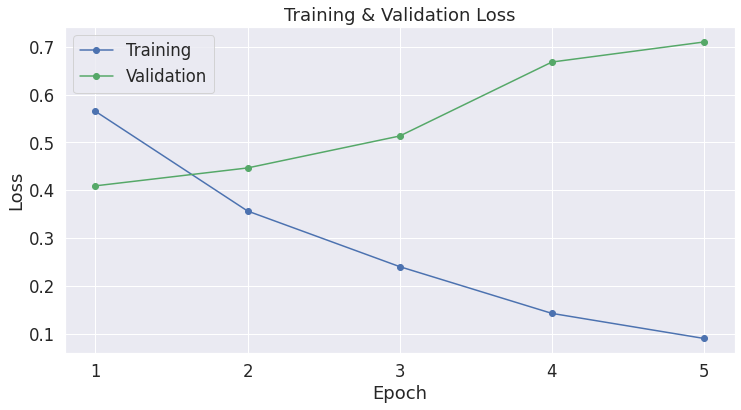

In [0]:
report_model_1(results_balanced)

In [0]:
results_balanced_split = train_val_gendermodel(train_loader=train_loader_balanced_split, val_loader=val_loader_balanced_split, epochs_val=5,seed_val=2020,device=device,lr_value=5e-5)

===========Starting Epoch 1 / 5 ==============
Training starts

  Average training loss: 0.50

Validation starts
  Accuracy: 0.77
  F1_score: 0.79
  Validation Loss: 0.48
===========Starting Epoch 2 / 5 ==============
Training starts

  Average training loss: 0.34

Validation starts
  Accuracy: 0.82
  F1_score: 0.82
  Validation Loss: 0.39
===========Starting Epoch 3 / 5 ==============
Training starts

  Average training loss: 0.22

Validation starts
  Accuracy: 0.83
  F1_score: 0.83
  Validation Loss: 0.49
===========Starting Epoch 4 / 5 ==============
Training starts

  Average training loss: 0.12

Validation starts
  Accuracy: 0.84
  F1_score: 0.84
  Validation Loss: 0.70
===========Starting Epoch 5 / 5 ==============
Training starts

  Average training loss: 0.06

Validation starts
  Accuracy: 0.84
  F1_score: 0.83
  Validation Loss: 0.82

Done !


       Train Loss  Val Loss  Val Accur.    Val F1
epoch                                            
1        0.496512  0.478547    0.765053  0.789926
2        0.343144  0.394375    0.824296  0.821352
3        0.224947  0.491861    0.826232  0.830963
4        0.115137  0.701325    0.836180  0.836075
5        0.058622  0.815139    0.837676  0.828122


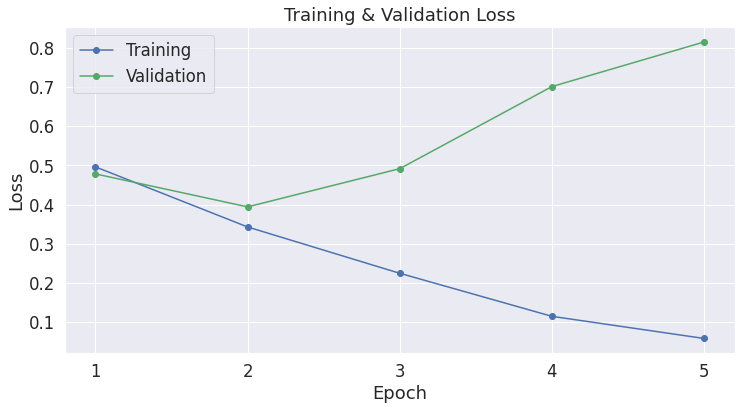

In [0]:
report_model_1(results_balanced_split)

Analyse

### Training the optimal model 

In [23]:
df_eval= balanced_splitted(df,seed_val,frac_val=1,max_tokens=500)

Number of text in this balanced splitted corpus : 10,326

Proportions of women in the balanced splitted corpus : 50.25179159403448



In [0]:
# We prepare another sample which will be dedicated to further qualitative analysis

In [25]:
len_train = round(0.97*len(df_eval))
df_balanced_split= df_eval[0:len_train]
dev_balanced_split=df_eval[len_train:len(df_eval)]

# Report the number of speeches in the corpus.
print('Number of text in this balanced splitted corpus : {:,}\n'.format(df_balanced_split.shape[0]))
print('Number of text in the development sample : {:,}\n'.format(dev_balanced_split.shape[0]))

Number of text in this balanced splitted corpus : 10,016

Number of text in the development sample : 310



In [0]:
#### NOT WORKING####train_loader_balanced_split, val_loader_balanced_split = prepare_to_feed(df_balanced_split,length=500,batch_size_value=16,length_train=0.9)

In [26]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

texts = df_balanced_split.Texte.values 
labels = df_balanced_split.sexe.values

torch.manual_seed(2020)
torch.cuda.manual_seed_all(2020)
length = 500
batch_size_value = 2
length_train=0.9

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
# Apply function to our corpus
for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = length,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
    input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
    attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])

# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)

# Let's create a 80-20 train / validation dataset 
train_size = int(length_train * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])


print("-------------------------------------------------")
print(" ")
print("How many texts do we have in the train and validation sample ? ")
print(" ")
print('We have {} training texts'.format(train_size))
print('We have {} validation texts'.format(val_size))
print(" ")
print("-------------------------------------------------")

# We set the size of the batch ( usually set around 16 or 32), we will take the lower bound because of the large text length
batch_size = batch_size_value

# We create data loaders for the train and validation dataset. 
train_loader_balanced_split = DataLoader(
            train_set,  # The training samples.
            sampler = RandomSampler(train_set), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

val_loader_balanced_split = DataLoader(
            val_set, # The validation samples.
            sampler = SequentialSampler(val_set), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

print('Data loaders created for train [0] and val [1]')

Let's check for the first text indexes, attention masks and labels
 
Original:  c'est plus que l'automobile, c'est un actif sur quinze, c'est un neuvième de nos exportations, c'est
IDs: tensor([    5,    60,    11,    41,    40,    27,    17,    11, 13208,     7,
           60,    11,    41,    23,  3338,    32,  6783,     7,    60,    11,
           41,    23,    21, 21945,     8,   166, 17818,     7,    60,    11,
           41,    17,    11,  6816,  3151,     9,   139,    44,   210,   143,
           40,   600,  2385,     9,   432,    13,  1618,   112,  2501,     8,
           13,  1133,  1636,     9,   432,    17,    11, 14837,     8,    13,
          400,  1024, 12976,     8,    72,    10,  4849,   994,    35,    37,
           17,    11,  1288,    36,   499,     8,  3201,     8,   713,     8,
          242,    29,    19,   256, 11931,    10,     9,   432,    99,    16,
        26057,  1823,    20, 20978,    10,   165,  4849,    79,    19,  7156])
Attention masks: tensor([1, 1, 1,

In [27]:
############################  IMPORT MODEL ################################################
from transformers import CamembertForSequenceClassification
gender_model = CamembertForSequenceClassification.from_pretrained("camembert-base", 
                                                                  num_labels = 2, 
                                                                  output_attentions = False, 
                                                                  output_hidden_states = False, )

gender_model.cuda()
############################## RANDOM SEED ##################################################

import random
seed=seed_val
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

############################### LEARNING RATE SCHEDULER #######################################

import torch.nn as nn
import torch.optim as optim
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

epochs = 3 

#Implements Adam algorithm with weight decay fix.
opti = AdamW(gender_model.parameters(),
              lr =5e-5, # learning rate (default = 1e-3)
              eps = 1e-8 # prevents division by 0 (default = 1e-8)
            )

num_training_steps = len(train_loader_balanced_split) * epochs

# Create a schedule with a learning rate that decreases linearly after linearly increasing during a warmup period (0 here)
scheduler = get_linear_schedule_with_warmup(opti, 
                                            num_warmup_steps = 0,
                                            num_training_steps = num_training_steps)


for ep in range(0, epochs):
  print('===========Starting Epoch {} / {} =============='.format(ep+1,epochs))
  print('Training starts')

  ################################### TRAINING ################################

  #Put the model in training mode
  gender_model.train()

  # Set the train loss for the epoch to 0 
  total_train_loss = 0

  for step, batch in enumerate(train_loader_balanced_split):
    # Clear gradients 
    gender_model.zero_grad() # 

    # Cpy the 3 batch to GPU 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    #return loss and logits
    loss, logits = gender_model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels) 
    
    # Accumulate training loss for all batches 
    total_train_loss += loss.item()

    #Backpropagating the gradients 
    loss.backward()

    # Prevent exploding gradients problem  (forcing the gradients to be small, the parameter updates will not push the parameters too far from their previous values)
    torch.nn.utils.clip_grad_norm_(gender_model.parameters(), 1.0)

    # Update parameters 
    opti.step()

    # Update learning rate schedule
    scheduler.step()

  #Calculate the average training loss over all batches  
  avg_train_loss = total_train_loss / len(train_loader_balanced_split)
  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))

===========Starting Epoch 1 / 3 ==============
Training starts

  Average training loss: 0.70
===========Starting Epoch 2 / 3 ==============
Training starts

  Average training loss: 0.66
===========Starting Epoch 3 / 3 ==============
Training starts

  Average training loss: 0.59


Let's compute some statistics on the performance of this final model

In [0]:
 def evaluation_loop(model,eval_loader): 
  # Put model in evaluation mode 
  model.eval()
  total_eval_loss,total_pred,total_label,total_logits=[],[],[],[]

  for batch in eval_loader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad(): 
      loss, logits = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
    #total_eval_loss += loss.item()

      # Move logits and labels to CPU 
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      pred= np.argmax(logits, axis=1).flatten()
      labels_flat = label_ids.flatten()

    # Accumulation accuracy for all batch
      total_pred += pred.tolist()

    # Accumulation f1 for all batch
      total_label += labels_flat.tolist()

      # Logits score on positive 
      total_logits += logits.tolist()

  return total_pred,total_label,total_logits

In [0]:
total_pred,total_label,total_logits =evaluation_loop(gender_model,val_loader_balanced_split)

In [0]:
def model_report(pred,label,logits):
    """
        Input :
            model : Algorithme de sklearn avec les paramètres choisit ou par défaut
            X_train,X_test,y_train,y_test : dataset découpé à l'aide de train_test_split
        Output : 
            Classification_report + Confusion_matrix + ROC_curve + (si possible feature importance)
    """
    #from sklearn
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
    logits = [el[1] for el in total_logits]
    pred = [i for i in total_pred]
    label = [i for i in total_label]
    print ("Classification report :")
    print(classification_report(label,pred))
    print ("Accuracy : ",accuracy_score(label,pred))
    cm = confusion_matrix(label,pred)
    ROC = roc_auc_score(label,pred) 
    print ("AUC : ",ROC)
    fpr,tpr,thresholds = roc_curve(label,logits)
    plt.figure(figsize=(12,10))
    plt.subplot(221)
    sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues').set_title('Matrice de confusion')
    plt.subplot(222)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % ROC)
    plt.plot([0,1],[0,1],color='red')
    plt.title('Courbe ROC')
    plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Classification report :
              precision    recall  f1-score   support

           0       0.79      0.76      0.77       481
           1       0.79      0.81      0.80       521

    accuracy                           0.79      1002
   macro avg       0.79      0.79      0.79      1002
weighted avg       0.79      0.79      0.79      1002

Accuracy :  0.7864271457085829
AUC :  0.7855275916696262


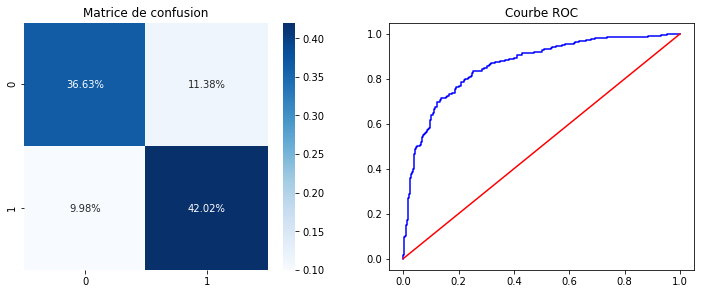

In [31]:
model_report(total_pred,total_label,logits)

## Evaluation and qualitative analysis 

Preparing development sequence 

We will use our development set we let outside of the analysis to make an attempt of qualitative analysis. 

In [0]:
# We prepare again the development sample for analysis 
def dev_prepare_to_feed(df,max_length_value,batch_size_value):
  from torch.utils.data import TensorDataset, random_split
  from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
  from transformers import CamembertTokenizer

  texts = df.Texte.values
  labels = df.sexe.values
  tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=False,padding_side='right')
  
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []
  num_truncated_tokens =[]

  for text in texts:
    encoded_dict = tokenizer.encode_plus(
                          text,                      # text
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = max_length_value,           # We choose for now a max length of 500.
                          pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                          return_attention_mask = True,   # Construct attention masks
                          return_tensors = 'pt',     # Return pytorch tensors.
                          return_overflowing_tokens =True, # return overflowing token information
                    )
      
      # Map tokens to their id in the dictionnary 
      # We add this to our list    
    input_ids.append(encoded_dict['input_ids'])

      #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
      
      # 3. Attention masks
    attention_masks.append(encoded_dict['attention_mask'])

  # We convert all this into tensors in order to be able to make it work on GPU 
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Original text and transformed tensor print 
  print("Let's check for the first text indexes, attention masks and labels")
  print(" ")
  print('Original: ', texts[0][0:100])
  print('IDs:', input_ids[0][0:100])
  print('Attention masks:', attention_masks[0][0:100])
  print('labels',labels[0])

  # Combine all above
  dataset = TensorDataset(input_ids, attention_masks, labels)
  # We create data loaders for the train and validation dataset. 
  dev_dataloader = DataLoader(
              dataset,  # The training samples.
              batch_size = batch_size_value, # Trains with this batch size.
              shuffle=False
          )
  return dev_dataloader

In [0]:
dev_dataloader=dev_prepare_to_feed(dev_balanced_split,max_length_value=500,batch_size_value=10)

Let's check for the first text indexes, attention masks and labels
 
Original:   J'ai plaisir à le souligner aujourd'hui devant vous tous, responsables des petites villes de France
IDs: tensor([   5,  121,   11,   73,  593,   15,   16, 8415,  405,   11,  265,  466,
          39,  117,    7, 2783,   20,  923, 1785,    8,  184,    9,    6,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1])
Attention masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [32]:
# We prepare again the development sample for analysis 

from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertTokenizer

texts = dev_balanced_split.Texte.values
labels = dev_balanced_split.sexe.values
tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=False,padding_side='right')

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]

for text in texts:
  encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 500,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
  input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
  attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])

# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)
# We create data loaders for the train and validation dataset. 
dev_dataloader = DataLoader(
            dataset,  # The training samples.
            batch_size = 16, # Trains with this batch size.
            shuffle=False
        )

Let's check for the first text indexes, attention masks and labels
 
Original:  1,7 milliards d'euros sur la période 2007-2013. Au total, ce sont 2,4 milliards d'euros que l'Etat i
IDs: tensor([    5,   124,     7,   959,  1885,    18,    11,  1958,    32,    13,
          782,  2598,    26,  8622,     9,   277,  1458,     7,    44,    56,
        27872,  1885,    18,    11,  1958,    27,    17,    11,  1184, 24721,
          564,    15,   689,    29,    17,    11,  1894,  2062,     8,    13,
         2117,     9,  5338, 10456,    20,  2697, 12426,    18,    11,    70,
         1323, 18541,    29,    17,    11,    70,    20, 10415,    19,    40,
        23527,    10,    25,   164,  1316,    72,  1402,    20,  2192,  8757,
            9,  1223,  5394,  3408,  4847,  1752,    18,    11,   105,   978,
            9,  1799,  2135,    55,    15,   208,    19,  8381,  6338,    10,
            7,    42,    23,   428,  1739,    43,  1027,    15,  3027,    18])
Attention masks: tensor([1, 1, 1,

In [33]:
dev_balanced_split

,index,index_df,sexe,Texte,Length
10016,3248,179171,1,"1,7 milliards d'euros sur la période 2007-2013...",500
10017,2148,207611,1,Projet de loi de financement de la sécurité so...,500
10018,2627,198959,1,"jeunes diplômés et demandeurs d'emploi, ces cl...",500
10019,2464,271813,1,forces spéciales françaises aux côtés des forc...,168
10020,5911,139911,0,"Monsieur le Ministre,Mesdames et Messieurs les...",500
...,...,...,...,...,...
10321,908,130641,1,la République.De cette double préoccupation de...,500
10322,4820,163869,1,sociétés d'assurances .Des mesures ont été pri...,500
10323,2565,269498,1,des ministres du 18 juillet a adopté une feuil...,500
10324,7495,204747,0,promeneurs en 2006. La législation impose aux ...,500


In [0]:
total_pred,total_labels,total_logits=evaluation_loop(gender_model,dev_dataloader)


In [0]:
# Extract the score for label 1 
one_score = [el[1] for el in total_logits]
max_score = np.max(total_logits,axis=1)
# Put everything inside a dataframe
results_dev=pd.DataFrame([total_labels,total_pred,one_score,max_score]).transpose()
results_dev.columns=['returned_labels','model_pred','one_score','max_score']
results_dev['WF']=pd.DataFrame([results_dev['model_pred']==results_dev['returned_labels']]).transpose()
# Merge back with the text
frames = [dev_balanced_split[['Texte','sexe','index_df']].reset_index(), results_dev]
result = pd.concat(frames,axis=1)

In [36]:
result

,index,Texte,sexe,index_df,returned_labels,model_pred,one_score,max_score,WF
0,10016,"1,7 milliards d'euros sur la période 2007-2013...",1,179171,1.0,1.0,1.925950,1.925950,True
1,10017,Projet de loi de financement de la sécurité so...,1,207611,1.0,1.0,2.411148,2.411148,True
2,10018,"jeunes diplômés et demandeurs d'emploi, ces cl...",1,198959,1.0,0.0,-2.042962,1.850508,False
3,10019,forces spéciales françaises aux côtés des forc...,1,271813,1.0,0.0,-1.922202,1.742192,False
4,10020,"Monsieur le Ministre,Mesdames et Messieurs les...",0,139911,0.0,0.0,-2.250015,2.040527,True
...,...,...,...,...,...,...,...,...,...
305,10321,la République.De cette double préoccupation de...,1,130641,1.0,0.0,-2.202817,1.994338,False
306,10322,sociétés d'assurances .Des mesures ont été pri...,1,163869,1.0,0.0,-1.959267,1.773017,False
307,10323,des ministres du 18 juillet a adopté une feuil...,1,269498,1.0,1.0,1.822989,1.822989,True
308,10324,promeneurs en 2006. La législation impose aux ...,0,204747,0.0,1.0,2.259435,2.259435,False


In [0]:
#Which texts failed ? 
print('{0:.2f} percent of the development texts were not well classified by our model'.format(result[result.WF==False].WF.count()*100/len(result)))

17.76 percent of the development texts were not well classified by our model


In [0]:
# We merge this dataframe to the information we had at the beginning
merged_results=result[['index','index_df','returned_labels','model_pred','one_score','max_score','WF']].merge(df,how='left',left_on='index_df',right_on='Id')

Now we are going to take 3 texts well classified and 3 other wrongly classified. We will try to take the ones the model as really sure about in the good or bad side.

In [0]:
top_texts_true=merged_results[merged_results.WF==1].nlargest(3,'max_score')
top_texts_false=merged_results[merged_results.WF==0].nlargest(3,'max_score')

In [0]:
top_texts_true

,index,index_df,returned_labels,model_pred,one_score,max_score,WF,Unnamed: 0,Id,Titre,Type,Theme,Prenom,Nom,Fonction,Date,Tags,Texte,Lien,PRENOM,preusuel,sexe
128,9945,176000,0.0,0.0,-2.415498,2.580664,True,14889,176000,"Déclaration de M. Bernard Kouchner, ministre d...",déclaration,Société,Bernard,Kouchner,NaN,2009-07-16T12:00:00Z,"Culture - Médias,Politique culturelle","Madame la Ministre,Monsieur le Directeur génér...",https://www.vie-publique.fr/discours/176000-de...,BERNARD,BERNARD,0
259,10076,162162,0.0,0.0,-2.403018,2.578912,True,12107,162162,"Déclaration de M. Nicolas Sarkozy, ministre de...",déclaration,Société,Nicolas,Sarkozy,NaN,2006-06-09T12:00:00Z,"Sécurité,Délinquance,Ordre public","Mesdames, Messieurs,Je vous ai réunis aujourd'...",https://www.vie-publique.fr/discours/162162-de...,NICOLAS,NICOLAS,0
152,9969,179250,0.0,0.0,-2.398858,2.573263,True,28704,179250,"Déclaration de M. Brice Hortefeux, ministre de...",déclaration,Société,Brice,Hortefeux,NaN,2010-06-12T12:00:00Z,"Sécurité,Police","Monsieur le préfet,Monsieur le député,Monsieur...",https://www.vie-publique.fr/discours/179250-de...,BRICE,BRICE,0


In [0]:
top_texts_false

,index,index_df,returned_labels,model_pred,one_score,max_score,WF,Unnamed: 0,Id,Titre,Type,Theme,Prenom,Nom,Fonction,Date,Tags,Texte,Lien,PRENOM,preusuel,sexe
51,9868,173030,1.0,0.0,-2.252967,2.399928,False,29371,173030,"Déclaration de Mme Rama Yade, secrétaire d'Eta...",déclaration,International,Rama,Yade,NaN,2008-11-12T12:00:00Z,"Relations internationales,Relations bilatérale...","Monsieur le Député, après douze jours d'inquié...",https://www.vie-publique.fr/discours/173030-de...,RAMA,RAMA,1
4,9821,207653,0.0,1.0,2.283976,2.283976,False,15395,207653,"Déclaration de M. Bernard Kouchner, ministre d...",déclaration,Société,Bernard,Kouchner,NaN,2001-12-06T12:00:00Z,"Santé - Protection sociale,Etablissement sanit...","Mesdames, Messieurs,Au printemps dernier, en p...",https://www.vie-publique.fr/discours/207653-de...,BERNARD,BERNARD,0
182,9999,206934,0.0,1.0,2.090272,2.090272,False,256,206934,"Déclaration de M. Edouard Philippe, Premier mi...",déclaration,Société,Edouard,Philippe,NaN,2018-10-15T12:00:00Z,"Santé - Protection sociale,Politique sociale","Madame la Présidente de l'UNCCAS, chère Joëlle...",https://www.vie-publique.fr/discours/206934-de...,EDOUARD,EDOUARD,0


We want to dive a bit into the model and see how it makes a choice and why it fails on thos 38 sentences. Let's take one of them. We will redo point 4 of TD4 to see the score reached by each word. 

In [0]:
def split_document_to_limit(MAX_TOKENS,df):
  lst= []
  for index,row in df.iterrows():
    identifiant = row.Id
    label = row.sexe
    phrase = []
    for token in row.Texte.split(' '):
      if len(phrase) < MAX_TOKENS:
        phrase.append(token)
      else:
        lst += [(identifiant,label,' '.join(phrase),len(phrase))]
        phrase = []
    if len(phrase)>1:
      lst += [(identifiant,label,' '.join(phrase),len(phrase))]
  return pd.DataFrame(lst,columns=['index_df','sexe','Texte','Length'])
def split_document_to_limit_phrases(MAX_TOKENS,df):
  lst= []
  for index,row in df.iterrows():
    identifiant = row.Id
    label = row.sexe
    phrase = ''
    for phrases in sent_detector_mano(row.Texte):
      if len(phrase.split(' ')) + len(phrases.split(' ')) < MAX_TOKENS:
        phrase+= " " + phrases
      else:
        lst += [(identifiant,label,phrase,len(phrase.split(' ')))]
        phrase = ''
    lst += [(identifiant,label,phrase,len(phrase.split(' ')))]
    phrase = ''
  return pd.DataFrame(lst,columns=['index_df','sexe','Texte','Length'])

In [0]:
sentence_to_analyse = pd.concat([top_texts_false,top_texts_true]).reset_index(drop=True)
sentence_to_analyse=split_document_to_limit_phrases(50,sentence_to_analyse)

In [0]:
max(sentence_to_analyse.Length)

49

In [0]:
dev_dataloader=dev_prepare_to_feed(sentence_to_analyse,max_length_value=55,batch_size_value=1)

Let's check for the first text indexes, attention masks and labels
 
Original:   Monsieur le Député, après douze jours d'inquiétude, nos sept compatriotes et un ressortissant tunis
IDs: tensor([    5,  2445,    16, 27891,     7,   182,  5972,   274,    18,    11,
        16035,     7,   166,  2085, 16681,    10,    14,    23,  4008,  2914,
        17773,     7,  3665,     8,    13,   426, 21530,     7,    56, 10540,
           10,    44,   823,    25,  9834,   182,   190,   101, 10508,    10,
            9,   121,    11,  1009,    15,    17,    11,  4220,     8, 28658,
           24,    19,  3468,    42,     6])
Attention masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1])
labels tensor(1)


In [0]:
total_pred,total_labels,total_logits =evaluation_loop(gender_model,dev_dataloader)

In [0]:
# Extract the score for label 1 
one_score = [el[1] for el in total_logits]
max_score = np.max(total_logits,axis=1)
# Put everything inside a dataframe
results_dev=pd.DataFrame([total_labels,total_pred,one_score,max_score]).transpose()
results_dev.columns=['returned_labels','model_pred','one_score','max_score']
results_dev['WF']=pd.DataFrame([results_dev['model_pred']==results_dev['returned_labels']]).transpose()
# Merge back with the text
frames = [sentence_to_analyse[['Texte','sexe','index_df']].reset_index(), results_dev]
result = pd.concat(frames,axis=1)

In [0]:
result

,index,Texte,sexe,index_df,returned_labels,model_pred,one_score,max_score,WF
0,0,"Monsieur le Député, après douze jours d'inqui...",1,173030,1.0,0.0,-1.061862,1.105137,False
1,1,"C'est aussi, vous l'avez souligné Monsieur le...",1,173030,1.0,0.0,-0.534817,0.521251,False
2,2,L'objectif était alors de les réconforter et ...,1,173030,1.0,0.0,-1.292707,1.359186,False
3,3,Je salue également les autorités nigérianes q...,1,173030,1.0,0.0,-1.711271,1.846850,False
4,4,"Que ce soit dans le golfe de Guinée, dans les...",1,173030,1.0,0.0,-1.268483,1.347814,False
...,...,...,...,...,...,...,...,...,...
266,266,"(3) Je n'oublie pas non plus que, durant ces ...",0,179250,0.0,1.0,0.940289,0.940289,False
267,267,"J'étais, hier, à Chamonix pour rendre hommage...",0,179250,0.0,0.0,-1.797531,1.923270,True
268,268,"Mesdames et Messieurs,Cette journée est une n...",0,179250,0.0,1.0,0.578052,0.578052,False
269,269,En incarnant la quintessence même des valeurs...,0,179250,0.0,0.0,-1.544272,1.646882,True


In [0]:
merged_results=result[['index','index_df','Texte','returned_labels','model_pred','one_score','max_score','WF']].merge(df[['Id','sexe']],how='left',left_on='index_df',right_on='Id')

In [0]:
#Which texts failed ? 
print('{0:.2f} percent of the development texts were not well classified by our model'.format(result[result.WF==False].WF.count()*100/len(result)))

41.33 percent of the development texts were not well classified by our model


In [0]:
merged_results

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Id,sexe
0,0,173030,"Monsieur le Député, après douze jours d'inqui...",1.0,0.0,-1.061862,1.105137,False,173030,1
1,1,173030,"C'est aussi, vous l'avez souligné Monsieur le...",1.0,0.0,-0.534817,0.521251,False,173030,1
2,2,173030,L'objectif était alors de les réconforter et ...,1.0,0.0,-1.292707,1.359186,False,173030,1
3,3,173030,Je salue également les autorités nigérianes q...,1.0,0.0,-1.711271,1.846850,False,173030,1
4,4,173030,"Que ce soit dans le golfe de Guinée, dans les...",1.0,0.0,-1.268483,1.347814,False,173030,1
...,...,...,...,...,...,...,...,...,...,...
266,266,179250,"(3) Je n'oublie pas non plus que, durant ces ...",0.0,1.0,0.940289,0.940289,False,179250,0
267,267,179250,"J'étais, hier, à Chamonix pour rendre hommage...",0.0,0.0,-1.797531,1.923270,True,179250,0
268,268,179250,"Mesdames et Messieurs,Cette journée est une n...",0.0,1.0,0.578052,0.578052,False,179250,0
269,269,179250,En incarnant la quintessence même des valeurs...,0.0,0.0,-1.544272,1.646882,True,179250,0


In [0]:
top_sentence_true=merged_results[merged_results.WF==1].nlargest(1,'max_score')
top_sentence_false=merged_results[merged_results.WF==0].nlargest(1,'max_score')

In [0]:
top_sentence_false

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Id,sexe
32,32,207653,Je souhaite par ailleurs que vous soyez dorén...,0.0,1.0,2.46695,2.46695,False,207653,0


In [0]:
top_sentence_true

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Id,sexe
93,93,176000,"Ce sujet, qui est celui de la reconstruction ...",0.0,0.0,-2.40031,2.571011,True,176000,0


In [0]:
words_to_analyse = pd.concat([top_sentence_false,top_sentence_true]).reset_index(drop=True)
words_to_analyse=split_document_to_limit(1,words_to_analyse)

In [0]:
words_to_analyse

,index_df,sexe,Texte,Length
0,207653,0,,1
1,207653,0,souhaite,1
2,207653,0,ailleurs,1
3,207653,0,vous,1
4,207653,0,dorénavant,1
5,207653,0,sous,1
6,207653,0,des,1
7,207653,0,"sages-femmes,",1
8,207653,0,chef,1
9,207653,0,service,1


In [0]:
dev_dataloader=dev_prepare_to_feed(words_to_analyse,max_length_value=3,batch_size_value=1)

Let's check for the first text indexes, attention masks and labels
 
Original:  
IDs: tensor([5, 6, 1])
Attention masks: tensor([1, 1, 0])
labels tensor(0)


In [0]:
total_pred,total_labels,total_logits =evaluation_loop(gender_model,dev_dataloader)

In [0]:
# Extract the score for label 1 
one_score = [el[1] for el in total_logits]
max_score = np.max(total_logits,axis=1)
# Put everything inside a dataframe
results_dev=pd.DataFrame([total_labels,total_pred,one_score,max_score]).transpose()
results_dev.columns=['returned_labels','model_pred','one_score','max_score']
results_dev['WF']=pd.DataFrame([results_dev['model_pred']==results_dev['returned_labels']]).transpose()
# Merge back with the text
frames = [words_to_analyse[['Texte','sexe','index_df']].reset_index(), results_dev]
result = pd.concat(frames,axis=1)

In [0]:
result

,index,Texte,sexe,index_df,returned_labels,model_pred,one_score,max_score,WF
0,0,,0,207653,0.0,1.0,-0.022262,-0.022262,False
1,1,souhaite,0,207653,0.0,1.0,-0.022137,-0.022137,False
2,2,ailleurs,0,207653,0.0,1.0,-0.021943,-0.021943,False
3,3,vous,0,207653,0.0,1.0,-0.021103,-0.021103,False
4,4,dorénavant,0,207653,0.0,1.0,-0.022120,-0.022120,False
5,5,sous,0,207653,0.0,1.0,-0.022071,-0.022071,False
6,6,des,0,207653,0.0,1.0,-0.022110,-0.022110,False
7,7,"sages-femmes,",0,207653,0.0,1.0,-0.022272,-0.022272,False
8,8,chef,0,207653,0.0,1.0,-0.021611,-0.021611,False
9,9,service,0,207653,0.0,1.0,-0.022001,-0.022001,False


In [0]:
scores = [i for i in result[result.index_df==176000].one_score]

In [0]:
df_plot=pd.DataFrame(scores).transpose()

In [0]:
df_plot.columns=list(result[result.index_df==176000].Texte)

In [0]:
df_plot

,,"sujet,",est,de,reconstruction,de,gouvernance,ces,est,sujet,pour,crédibilité,notre,Mesdames,"Messieurs,",le,je,suis,dans,rénovation,notre
0,-0.022262,-0.021496,-0.022119,-0.020978,-0.02221,-0.020978,-0.021977,-0.022007,-0.022119,-0.021496,-0.02175,-0.022082,-0.022191,-0.021963,-0.022156,-0.021482,-0.022094,-0.021706,-0.022218,-0.022238,-0.022191


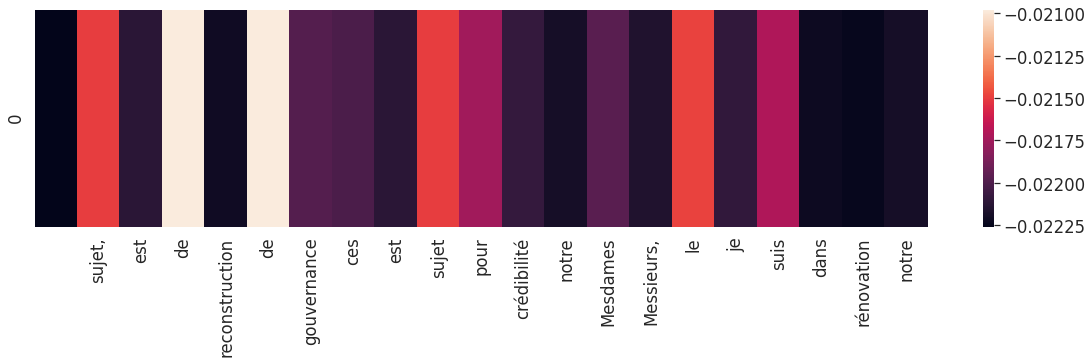

In [0]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

 
# Default heatmap: just a visualization of this square matrix
fig, ax = plt.subplots(figsize=(20,4)) 
sns.heatmap(df_plot)
plt.show()


Faire des annotations pour la fin du doc et nettoyer mettre en forme
Faire des fonctions pour la fin 
Amélioer le graphique . Est ce que c'est intelligent par mot ? 
Remplacer score max par la moyenne des logits à chercher à la fin du train 
Analyser un peu et mettre au propre sur la feuille


# Test 

,index,index_df,sexe,Texte,Length
0,8844,163979,0,163979,444
1,3971,192898,1,192898,443
2,1813,191962,1,191962,439
3,2254,147466,1,147466,403
4,1704,173140,1,173140,419
...,...,...,...,...,...
11192,3655,175003,1,175003,208
11193,1661,180667,1,180667,429
11194,2139,205519,1,205519,229
11195,7491,185081,0,185081,428


In [0]:
# Import Camembert tokenizer
from transformers import CamembertTokenizer
# We choose a right padding side for the moment and we will test for a left padding side on a second stage
tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=False,padding_side='right') #left

In [0]:

from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

texts = df_balanced_split.Texte.values
labels = df_balanced_split.sexe.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
# Apply function to our corpus
for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 500,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
    input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
    attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])


# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)

# Let's create a 80-20 train / validation dataset 
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])


print("-------------------------------------------------")
print(" ")
print("How many texts do we have in the train and validation sample ? ")
print(" ")
print('We have {} training texts'.format(train_size))
print('We have {} validation texts'.format(val_size))
print(" ")
print("-------------------------------------------------")

# We set the size of the batch ( usually set around 16 or 32), we will take the lower bound because of the large text length
batch_size = 16

# We create data loaders for the train and validation dataset. 
train_dataloader = DataLoader(
            train_set,  # The training samples.
            sampler = RandomSampler(train_set), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

val_dataloader = DataLoader(
            val_set, # The validation samples.
            sampler = SequentialSampler(val_set), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

print('Data loaders created for train [0] and val [1]')

Let's check for the first text indexes, attention masks and labels
 
Original:  la spécialisation des navires ; un nombre supérieur de moyens d'observation, de communication et de 
IDs: tensor([    5,    13, 20831,    20, 11013,   167,    23,   365,  2062,     8,
         1149,    18,    11,  7064,     7,     8,  1006,    14,     8,  9888,
          167,     8,   704,  1979,    18,    11,  7781,   167,    20,  3768,
           18,    11,  3064, 12914, 17441, 19963,    80,    24,    98,    22,
          586,    18,    11,  4976,  6916,    36,   731,     8, 12463,    10,
            7,    22,    21, 14319,    17,    11,   649,    20,   592, 10424,
           37,    19,   678, 13957,     8,  1983, 16111,   167,    13,  2966,
            7,   743,     7,    18,    11,  2688,    13,  9157,   128,    20,
        11013,    14,  1979,    18,    11,  7781,  4993,    14,    18,    11,
          266,    40,  2294,     7,    66,    22, 26634,   172,    16,  1984])
Attention masks: tensor([1, 1, 1,

In [0]:
results_unbalanced = train_val_gendermodel(train_loader=train_dataloader, val_loader=val_dataloader, epochs_val=5,seed_val=2020,device=device,lr_value=5e-5)

===========Starting Epoch 1 / 5 ==============
Training starts

  Average training loss: 0.51

Validation starts
  Accuracy: 0.80
  F1_score: 0.80
  Validation Loss: 0.43
===========Starting Epoch 2 / 5 ==============
Training starts

  Average training loss: 0.36

Validation starts
  Accuracy: 0.82
  F1_score: 0.81
  Validation Loss: 0.41
===========Starting Epoch 3 / 5 ==============
Training starts

  Average training loss: 0.23

Validation starts
  Accuracy: 0.84
  F1_score: 0.83
  Validation Loss: 0.49
===========Starting Epoch 4 / 5 ==============
Training starts

  Average training loss: 0.13

Validation starts
  Accuracy: 0.83
  F1_score: 0.83
  Validation Loss: 0.66
===========Starting Epoch 5 / 5 ==============
Training starts

  Average training loss: 0.06

Validation starts
  Accuracy: 0.82
  F1_score: 0.81
  Validation Loss: 0.79

Done !


       Train Loss  Val Loss  Val Accur.    Val F1
epoch                                            
1        0.506192  0.425347    0.798632  0.800964
2        0.359642  0.408357    0.819022  0.813722
3        0.229572  0.491328    0.836753  0.833890
4        0.132649  0.656070    0.827001  0.826271
5        0.060629  0.793369    0.823582  0.813131


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


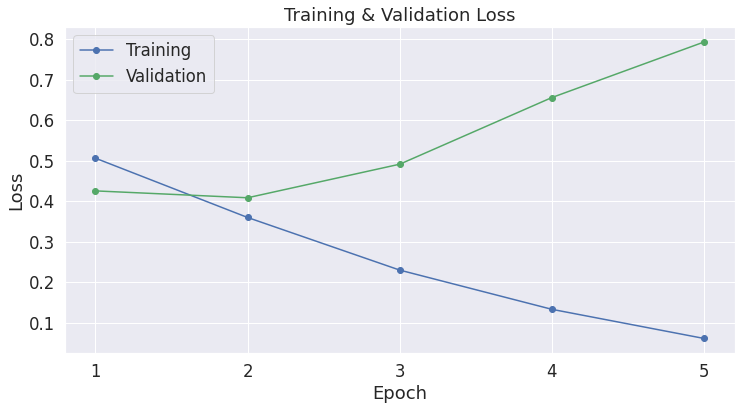

In [0]:
report_model_1(results_unbalanced)

In [0]:
############################  IMPORT MODEL ################################################
from transformers import CamembertForSequenceClassification
gender_model = CamembertForSequenceClassification.from_pretrained(
  "camembert-base", 
  num_labels = 2, # We have two different labels Women = 1 and Men =0   
  output_attentions = False, 
  output_hidden_states = False, )

model = gender_model
model.cuda()

lr_value = 5e-5
train_loader=train_dataloader
val_loader=val_dataloader
epochs_val=3
seed_val=2020
device=device
lr_value=5e-5

############################## RANDOM SEED ##################################################

import random
# Let's put a seed to make this result reproducible 
seed=seed_val
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

############################### LEARNING RATE SCHEDULER #######################################

# https://huggingface.co/transformers/migration.html 
# https://pytorch.org/docs/stable/optim.html (default values)

import torch.nn as nn
import torch.optim as optim
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

epochs = epochs_val # In order to fine tune our model we will first set the number of epochs to 4.

# We choose Binary cross enthropy with logits loss for the loss computation. It seems to be the most adapted loss to our problem. 
criterion = nn.BCEWithLogitsLoss()
#Implements Adam algorithm with weight decay fix.
opti = AdamW(model.parameters(),
                  lr =lr_value, # learning rate (default = 1e-3)
                  eps = 1e-8 # prevents division by 0 (default = 1e-8)
                )

num_training_steps = len(train_loader) * epochs
# Create a schedule with a learning rate that decreases linearly after linearly increasing during a warmup period (0 here)
scheduler = get_linear_schedule_with_warmup(opti, 
                                            num_warmup_steps = 0,
                                            num_training_steps = num_training_steps)


# We want to evaluate the training phase 
training_stats = []

for ep in range(0, epochs):
  print('===========Starting Epoch {} / {} =============='.format(ep+1,epochs))
  print('Training starts')

  ################################### TRAINING ################################

  #Put the model in training mode
  model.train()

  # Set the train loss for the epoch to 0 
  total_train_loss = 0

  for step, batch in enumerate(train_loader):
    # Clear gradients 
    model.zero_grad() # (opti.zerograd ? )

    # Cpy the 3 batch to GPU 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    #return loss and logits
    loss, logits = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels) 
    
    # Accumulate training loss for all batches 
    total_train_loss += loss.item()

    #Backpropagating the gradients 
    loss.backward()

    # Prevent exploding gradients problem  (forcing the gradients to be small, the parameter updates will not push the parameters too far from their previous values)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters 
    opti.step()

    # Update learning rate schedule
    scheduler.step()

  #Calculate the average training loss over all batches  
  avg_train_loss = total_train_loss / len(train_loader)
  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print('')
  print('Validation starts')

  ###################### VALIDATION #############################

  # Put model in evaluation mode 
  model.eval()

  # Set statistics to 0
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0
  total_eval_f1=0
  total_roc_auc = 0 

  # Confusion matrix ?
  predictions, true_labels = [], []

  for batch in val_loader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    # We don't care about gradients for eval

    with torch.no_grad(): 
      (loss, logits) = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
    total_eval_loss += loss.item()

      # Move logits and labels to CPU 
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    F1_score, Accuracy = create_report(label_ids,logits)

    # Accumulation accuracy for all batch
    total_eval_accuracy += Accuracy

    # Accumulation f1 for all batch
    total_eval_f1 += F1_score
    
    #Final accuracy on all batch
  avg_val_accuracy = total_eval_accuracy / len(val_loader)
  print("  Accuracy: {0:.2f}".format(avg_val_accuracy))


    #Final f1 on all batch
  avg_val_f1 = total_eval_f1 / len(val_loader)
  print("  F1_score: {0:.2f}".format(avg_val_f1))

    #Final loss over all batch
  avg_val_loss = total_eval_loss / len(val_loader)
  print("  Validation Loss: {0:.2f}".format(avg_val_loss))

  training_stats.append(
        {
            'epoch': ep + 1,
            'Train Loss': avg_train_loss,
            'Val Loss': avg_val_loss,
            'Val Accur.': avg_val_accuracy,
            'Val F1' : avg_val_f1,
        }
    )

print("")
print("Done !")

===========Starting Epoch 1 / 3 ==============
Training starts

  Average training loss: 0.51

Validation starts
  Accuracy: 0.85
  F1_score: 0.52
  Validation Loss: 0.43
===========Starting Epoch 2 / 3 ==============
Training starts

  Average training loss: 0.36

Validation starts
  Accuracy: 0.86
  F1_score: 0.62
  Validation Loss: 0.34
===========Starting Epoch 3 / 3 ==============
Training starts

  Average training loss: 0.27

Validation starts
  Accuracy: 0.83
  F1_score: 0.61
  Validation Loss: 0.40

Done !


       Train Loss  Val Loss  Val Accur.    Val F1  accur 2 
epoch                                                      
1        0.486057  0.393362      0.8500  0.502009    0.8500
2        0.340707  0.359600      0.8525  0.507469    0.8525
3        0.244166  0.372269      0.8650  0.637284    0.8650


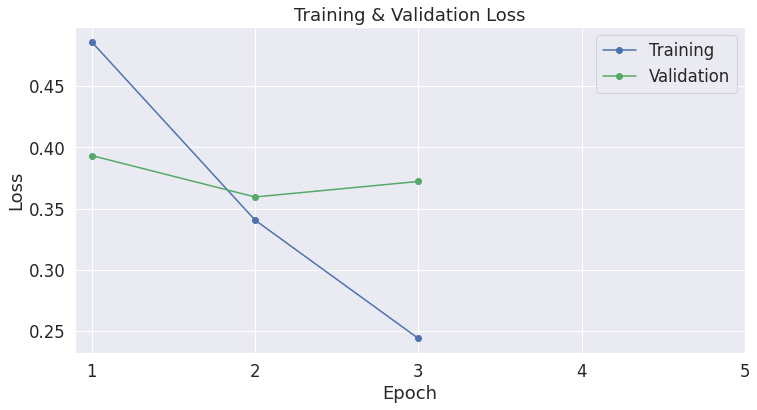

In [0]:
report_model_1(results_unbalanced)

In [0]:
results_unbalanced = train_val_gendermodel(train_loader=train_loader_unbalanced, val_loader=val_loader_unbalanced, epochs_val=3,seed_val=2020,device=device,lr_value=5e-5)

===========Starting Epoch 1 / 3 ==============
Training starts

  Average training loss: 0.65

Validation starts
  Accuracy: 0.76
  Accuracy: 0.76
  F1_score: 0.60
  Validation Loss: 0.60
===========Starting Epoch 2 / 3 ==============
Training starts

  Average training loss: 0.66

Validation starts
  Accuracy: 0.76
  Accuracy: 0.76
  F1_score: 0.60
  Validation Loss: 0.65
===========Starting Epoch 3 / 3 ==============
Training starts

  Average training loss: 0.66

Validation starts
  Accuracy: 0.76
  Accuracy: 0.76
  F1_score: 0.60
  Validation Loss: 0.61

Done !


In [0]:
PROBLEM DANS LE LOAD 

In [0]:

from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

texts = df.Texte.values
labels = df.sexe.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
# Apply function to our corpus
for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = length,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
    input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
    attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])

NameError: ignored

In [0]:
# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)

# Let's create a 80-20 train / validation dataset 
train_size = int(length_train * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])

# We set the size of the batch ( usually set around 16 or 32), we will take the lower bound because of the large text length
batch_size = batch_size_value

# We create data loaders for the train and validation dataset. 
train_dataloader = DataLoader(
            train_set,  # The training samples.
            sampler = RandomSampler(train_set), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

val_dataloader = DataLoader(
            val_set, # The validation samples.
            sampler = SequentialSampler(val_set), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

print('Data loaders created for train [0] and val [1]')



In [0]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

texts = df.Texte.values
labels = df.sexe.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
# Apply function to our corpus
for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = length,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
    input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
    attention_masks.append(encoded_dict['attention_mask'])


NameError: ignored